In [ ]:
import numpy as np

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from scipy import stats

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F
torch.manual_seed(1)

import time
from datetime import datetime

from collections import defaultdict
from collections import Counter

from random import randint
import pickle

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('error')

import string
# puncs = set(string.punctuation)

In [14]:
portion = 29000

#training sets
with open('tokenized_low.BPE.en') as f:
    train_en = [l.strip() for l in f.readlines()][:portion]
with open('tokenized_low.BPE.fr') as f:
    train_fr = [l.strip() for l in f.readlines()][:portion]

#validation sets
with open('val_tokenized_low.BPE.en') as f:
    val_en = [l.strip() for l in f.readlines()]
with open('val_tokenized_low.BPE.fr') as f:
    val_fr = [l.strip() for l in f.readlines()]

#test sets
with open('test_tokenized.BPE.en') as f:
    test_en = [l.strip() for l in f.readlines()]
with open('test_tokenized.BPE.fr') as f:
    test_fr = [l.strip() for l in f.readlines()]

In [15]:
#TODO
# 0 PAD - padding 0 for convenience in masking?
# 1 BOS - beginning of sentence
# 2 EOS - end of sentence
# 3 UNK - unknown

In [16]:
max_sentence_length = 100

In [17]:
def tokens_sentences(sentences):
    tokens_list = []
    sentence_list = []
    for s in sentences:
        split_sent = s.split()
        sentence = []
        for w in split_sent:
#             if w not in puncs:
            tokens_list.append(w)
            sentence.append(w)

        sentence_list.append(sentence)
    
    return tokens_list, sentence_list

In [18]:
tokens_list,sentence_list = tokens_sentences(train_en)

print(tokens_list[4])
print(sentence_list[0][4])

print(len(tokens_list))
print(len(sorted(set(tokens_list))))
# print(set(tokens_list))

m@@
m@@
563773
812


In [19]:
tokens_list_en, sentence_list_en = tokens_sentences(train_en)

tokens_train_en = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
tokens_train_en.extend(list(sorted(set(tokens_list_en))))
vocab_size_en = len(tokens_train_en)
print('Vocabulary size EN', vocab_size_en)

count_tokens_train_en = Counter(tokens_list_en)

tokens_list_fr, sentence_list_fr = tokens_sentences(train_fr)

tokens_train_fr = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
tokens_train_fr.extend(list(sorted(set(tokens_list_fr))))
vocab_size_fr = len(tokens_train_fr)
print('Vocabulary size FR', len(tokens_train_fr))

count_tokens_train_fr = Counter(tokens_list_fr)

Vocabulary size EN 816
Vocabulary size FR 862


In [20]:
def get_id_dicts(tokens):
    #default dictionary key:id value:token
    id2tokens = defaultdict(str)

    for i in range(len(tokens)):
        id2tokens[i] = tokens[i]

    #default dictionary key:token value:id
    tokens2id = defaultdict(int)

    for ind in id2tokens:
        tokens2id[id2tokens[ind]] = ind

    return tokens2id, id2tokens

In [21]:
tokens2id_en, id2tokens_en = get_id_dicts(tokens_train_en)

vocabulary_size_train_en = len(tokens2id_en)
print(vocabulary_size_train_en)

tokens2id_fr, id2tokens_fr = get_id_dicts(tokens_train_fr)

vocabulary_size_train_fr = len(tokens2id_fr)
print(vocabulary_size_train_fr)

# print(tokens2id_en['m@@'])
# print(id2tokens_en[1])

816
862


In [22]:
#building the corpora (list of list of ids) simultaneously 
def convert_corpora2id_both(sentence_list_en, sentence_list_fr, tokens2id_en, tokens2id_fr, max_sentence_length):
    
    #counts to check long sentences
    counter_long = 0
    
    #convert dataset to ids
    corpus2id_en = []
    corpus2id_fr = []
    
    for s in range(len(sentence_list_en)):
    
        sentence2id_en = []
        sentence2id_en.append(tokens2id_en['<SOS>'])
        
        sentence2id_fr = []
        sentence2id_fr.append(tokens2id_fr['<SOS>'])
        
        sentence_en = sentence_list_en[s]
        sentence_fr = sentence_list_fr[s]
        
        
        for w_en in sentence_en:
            word_id = tokens2id_en[w_en]
            sentence2id_en.append(word_id)
            
        for w_fr in sentence_fr:
            word_id = tokens2id_fr[w_fr]
            sentence2id_fr.append(word_id)
        
        
        sentence2id_en.append(tokens2id_en['<EOS>'])
        sentence2id_fr.append(tokens2id_fr['<EOS>'])

        if len(sentence2id_en) < max_sentence_length and len(sentence2id_fr) < max_sentence_length:
            corpus2id_en.append(sentence2id_en)
            corpus2id_fr.append(sentence2id_fr)
        
        else:
            counter_long += 1
#             print(sentence_list_en[s])
#             print(sentence_list_fr[s])
        
    print('the number of sentences that were not added is',counter_long)       
    return corpus2id_en, corpus2id_fr

In [23]:
corpus2id_en, corpus2id_fr = convert_corpora2id_both(sentence_list_en,sentence_list_fr, tokens2id_en, tokens2id_fr, max_sentence_length)

the number of sentences that were not added is 0


In [24]:
# print(corpus2id_en[0])

print('there are ', len(corpus2id_fr), 'french sentences')
print('there are ', len(corpus2id_en), 'english sentences')

there are  29000 french sentences
there are  29000 english sentences


In [25]:
#get test sentences 

test_tokens_list_en,test_sentence_list_en = tokens_sentences(test_en)
test_tokens_list_fr,test_sentence_list_fr = tokens_sentences(test_fr)

test_corpus2id_en, test_corpus2id_fr = convert_corpora2id_both(test_sentence_list_en,test_sentence_list_fr, tokens2id_en, tokens2id_fr, max_sentence_length)

the number of sentences that were not added is 0


In [26]:
def evaluate_sent(model_NMT, sent_fr, sent_en):
    
    with torch.no_grad():
        
        sent_fr = torch.tensor(np.asarray(sent_fr), dtype= torch.long)
        sent_en = torch.tensor(np.asarray(sent_en), dtype= torch.long)

        pos_fr = torch.tensor(np.asarray([p for p in range(len(sent_fr))]))
        pos_en = torch.tensor(np.asarray([p for p in range(len(sent_en))]))

#         average_context, stacked_contexts = model_encoder(sent_fr, pos_fr)
        
#         decoder_outputs, decoder_attentions = model_decoder(sent_en, average_context, stacked_contexts, train=False)
        
        decoder_outputs, decoder_attentions = model_NMT(sent_fr, pos_fr, sent_en, train=False)
        
    return decoder_outputs, decoder_attentions

In [27]:
def word_ids2string(sentence, id2token):
    
    converted = []

    for s in sentence:
        converted.append(id2token[s])
        
    return converted

In [34]:
#write the results of the predicted sentences to a txt file for evaluation

def write_test_eval(model_NMT, test_sentences_fr, test_sentences_en, portion, e, label):

    filename = 'test_results_' + portion + '_' + e + '_' + label + '.txt'
    output = open(filename,"w") 
    
    for sent in range(len(test_sentences_fr)):

        decoder_outputs, decoder_attentions = evaluate_sent(model_NMT, test_sentences_fr[sent], test_sentences_en[sent])
        
        output_list = word_ids2string(decoder_outputs, id2tokens_en)
        if '<EOS>' in output_list:
            output_list.remove('<EOS>')
        
        output_string = (" ").join(output_list)
        
        output.write(output_string + "\n")

    output.close()
    

In [31]:
def visualize_attention(S,sent_num):
    
    #model_encoder, model_decoder, sent_en, sent_fr
    
    #************************************************************************
    # S is the log softmax version of S, also a torch Tensor! (actually more acurately it's a Variable(Tensor(..))
    #************************************************************************

    S = S.exp()
    
    # Plot the attention tensor
    plt.clf()
    numpy_S = S.data.numpy()
    numpy_S = numpy_S[:,:,0]
    #print(numpy_S.shape)

    plt.imshow(numpy_S)
    imname = "attentions-test-" + str(sent_num)
    plt.savefig(imname)


In [30]:
import matplotlib.ticker as ticker

def showAttention(input_sentence, output_words, attentions, sentence_number):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    attentions = attentions.exp()
    cax = ax.matshow(attentions[:,:,0].data.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    imname = "attentions-test-" + str(sentence_number)
    plt.savefig(imname)
    plt.show()
  

In [32]:
#bilinear

class NMTModel(nn.Module):
    def __init__(self,vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length, vocab_size_en, dropout_prob):
        super(NMTModel, self).__init__()
        
        self.encoder = Encoder(vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length,dropout_prob)
        self.decoder = Decoder(dec_embedding_dim, vocab_size_en, max_sentence_length, dropout_prob)
            
    def forward(self, sent_fr, pos_fr, sent_en, train):
        
        stacked_contexts, ht = self.encoder(sent_fr, pos_fr,train)
        
        pred, attention_weights = self.decoder(sent_en, stacked_contexts, ht, train)
          
        return pred, attention_weights


# In[ ]:



class Encoder(nn.Module):
    def __init__(self,vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length, dropout_prob):
        super(Encoder, self).__init__()
        
        self.vocab_size_fr = vocab_size_fr
        self.max_sentence_length = max_sentence_length
        
        self.w_embedding_dim = w_embedding_dim
        self.p_embedding_dim = p_embedding_dim
        
        initrange = 0.5 / self.w_embedding_dim
        self.dec_embedding_dim = dec_embedding_dim
        
        #encoder
        self.w_embeddings = nn.Embedding(self.vocab_size_fr, self.w_embedding_dim)
        self.p_embeddings = nn.Embedding(self.max_sentence_length, self.p_embedding_dim)
        
        self.w_embeddings.weight.data.uniform_(-initrange, initrange)
        self.p_embeddings.weight.data.uniform_(-initrange, initrange)
        
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(self.dropout_prob)
        
        self.context_emb_dim = self.w_embedding_dim + self.p_embedding_dim
                
        
    def forward(self, sent_fr, pos_fr,train):
        
        #embedded = self.embedding(input).view(1, 1, -1)
        #TODO:BATCH
       
        ws = self.w_embeddings(sent_fr)
        ps = self.p_embeddings(pos_fr)
        es = torch.cat((ws, ps), 1)
        
        if train:
            es = self.dropout(es)
        else:
            es =  (1-self.dropout_prob)*es
        
        stacked_contexts = es
        average_context = torch.mean(stacked_contexts, dim = 0)
        
        return stacked_contexts, average_context

class Decoder(nn.Module):
    def __init__(self, dec_embedding_dim, vocab_size_en, max_sentence_length, dropout_prob):
        super(Decoder, self).__init__()
        
        self.vocab_size_en = vocab_size_en
        self.max_sentence_length = max_sentence_length
        
        self.dec_embedding_dim = dec_embedding_dim*2
        
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(self.dropout_prob)
        
        initrange = 0.5 / self.dec_embedding_dim
        self.embedding = nn.Embedding(self.vocab_size_en, self.dec_embedding_dim)
        
        self.embedding.weight.data.uniform_(-initrange, initrange)        
        
        self.lstm = nn.LSTM(self.dec_embedding_dim, self.dec_embedding_dim)
       
        self.bilinear_att = nn.Linear(self.dec_embedding_dim, self.dec_embedding_dim, bias = False)
        #a linear layer after this before softmax
        self.out_affine = nn.Linear(self.dec_embedding_dim*2, self.vocab_size_en)
               
    
    def forward(self, gold_target_sent, encoder_stacked_contexts, encoder_avg_context, train):
        
        if train:
            pred = []
            attentions = []

            embeds = self.embedding(gold_target_sent)
            embeds = self.dropout(embeds)

            output, (hidden, cell) = self.lstm(embeds.view(-1,1,self.dec_embedding_dim ),(encoder_avg_context.view(1, 1, -1), encoder_avg_context.view(1,1,-1)))

            #print(output[-1], hidden) same
            
            
            for w in range(len(gold_target_sent)-1):

                sw = output[w]
                
                cj = F.softmax(torch.matmul(self.bilinear_att(sw),torch.transpose(encoder_stacked_contexts,0,1)), dim = 1)
                
                c_vec = cj.view(-1,1) *  encoder_stacked_contexts.squeeze()
                
                c_vec = torch.sum(c_vec, dim=0).view(1,-1)
                
                sw = torch.cat((sw, c_vec),dim=1)
                
                s_output = self.out_affine(sw)
                s_output = F.log_softmax(s_output, dim=1)

                pred.append(s_output)
                
                attentions.append(cj)
                
            attentions = torch.stack(attentions, dim=0)

            pred = torch.stack(pred, dim=1)

            return pred, attentions
        
        
        else: #test
            
            decoder_outputs = []
            decoder_attentions = []
        
            test_word = torch.tensor(np.asarray([tokens2id_en['<SOS>']]), dtype = torch.long)
            
            test_word_id = tokens2id_en['<SOS>']
            
            for w in range(self.max_sentence_length):
       
                if test_word_id == tokens2id_en['<EOS>']:
                    
                    break  
                    
                output = self.embedding(test_word)
                
                output =  (1-self.dropout_prob)*output         
            
            
                if w == 0:
            
                    output, (hidden,cell) = self.lstm(output.view(1, 1, -1), (encoder_avg_context.view(1, 1, -1),encoder_avg_context.view(1, 1, -1)))
                    prev_hidden = hidden
                
                    sw = output[0]
                    
                    cj = F.softmax(torch.matmul(self.bilinear_att(sw),torch.transpose(encoder_stacked_contexts,0,1)), dim = 1)
                    
                    c_vec = cj.view(-1,1) *  encoder_stacked_contexts.squeeze()

                    c_vec = torch.sum(c_vec, dim=0).view(1,-1)

                    sw = torch.cat((sw, c_vec),dim=1)

                    s_output = self.out_affine(sw)
                    s_output = F.log_softmax(s_output, dim=1)
                    
                    test_word_id = int(torch.argmax(s_output))
                    test_word = torch.tensor(np.asarray([test_word_id]), dtype = torch.long)
           
                else:
                    output, (hidden,cell) = self.lstm(output.view(1, 1, -1), (prev_hidden.view(1, 1, -1),encoder_avg_context.view(1, 1, -1)))
                    prev_hidden = hidden

                    sw = output[0]
                    
                    cj = F.softmax(torch.matmul(self.bilinear_att(sw),torch.transpose(encoder_stacked_contexts,0,1)), dim = 1)
                    
                    c_vec = cj.view(-1,1) *  encoder_stacked_contexts.squeeze()

                    c_vec = torch.sum(c_vec, dim=0).view(1,-1)

                    sw = torch.cat((sw, c_vec),dim=1)

                    s_output = self.out_affine(sw)
                    s_output = F.log_softmax(s_output, dim=1)
                    
                    test_word_id = int(torch.argmax(s_output))
                    test_word = torch.tensor(np.asarray([test_word_id]), dtype = torch.long)
           
                 
                decoder_attentions.append(cj)
                
                decoder_outputs.append(test_word_id)
                
            decoder_attentions = torch.stack(decoder_attentions, dim=0)
                
            return decoder_outputs, decoder_attentions
    


# In[ ]:


epochs = 10
learning_rate = 0.1
w_embedding_dim = 100
p_embedding_dim = 100
dec_embedding_dim = 100
dropout_prob = 0.1

# model_encoder = Encoder(vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length)
# model_decoder = Decoder(dec_embedding_dim, vocab_size_en, max_sentence_length, dropout_prob)
model_NMT = NMTModel(vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length, vocab_size_en, dropout_prob)

optimizer_NMT = optim.SGD(model_NMT.parameters(), lr = learning_rate)
# optimizer_encoder = optim.SGD(model_encoder.parameters(), lr = learning_rate)
# optimizer_decoder = optim.SGD(model_decoder.parameters(), lr = learning_rate)

loss_func = nn.NLLLoss()
losses = []
avg_losses = []

portion = 10000

train = True
print('epoch, total loss, duration')
for e in range(epochs):
    
    then = datetime.now()
    
    total_loss = 0.0
    for s in range(portion):
     
        current_input = corpus2id_fr[s]
        gold_output = corpus2id_en[s]
        
        if len(current_input) > 0 and len(gold_output) > 0:
            
            optimizer_NMT.zero_grad()
            
            sent_fr = torch.tensor(np.asarray(current_input), dtype= torch.long)
            sent_en = torch.tensor(np.asarray(gold_output), dtype= torch.long)

            pos_fr = torch.tensor(np.asarray([p for p in range(len(sent_fr))]))
            pos_en = torch.tensor(np.asarray([p for p in range(len(sent_en))]))
        
            pred, attention_weights = model_NMT(sent_fr, pos_fr, sent_en, train)
            
            sent_en = sent_en[1:len(sent_en)] #skip SOS
            loss = loss_func(pred[0], sent_en)
            loss.backward()
            
            optimizer_NMT.step()
            
            total_loss += loss.item() 
       
    now = datetime.now()
        
    losses.append(total_loss/portion)
    
    print(e, total_loss/portion, now-then)

    with open('model_NMT_bil_' + str(portion) + '_'+str(e)+'.pickle','wb') as file:
        pickle.dump(model_NMT,file)
        
    
with open('loss_bil_' + str(portion) + '_' +str(e) + '.txt','wb') as file:
    pickle.dump(losses,file)
        


epoch, total loss, duration


KeyboardInterrupt: 

In [ ]:
#bilinear with gru

class NMTModel(nn.Module):
    def __init__(self,vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length, vocab_size_en, dropout_prob):
        super(NMTModel, self).__init__()
        
        self.encoder = Encoder(vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length,dropout_prob)
        self.decoder = Decoder(dec_embedding_dim, vocab_size_en, max_sentence_length, dropout_prob)
            
    def forward(self, sent_fr, pos_fr, sent_en, train):
        
        stacked_contexts, ht = self.encoder(sent_fr, pos_fr,train)
        
        pred, attention_weights = self.decoder(sent_en, stacked_contexts, ht, train)
          
        return pred, attention_weights

class Encoder(nn.Module):
    def __init__(self,vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length, dropout_prob):
        super(Encoder, self).__init__()
        
        self.vocab_size_fr = vocab_size_fr
        self.max_sentence_length = max_sentence_length
        
        self.w_embedding_dim = w_embedding_dim
        self.p_embedding_dim = p_embedding_dim
        
        initrange = 0.5 / self.w_embedding_dim
        self.dec_embedding_dim = dec_embedding_dim
        
        #encoder
        self.w_embeddings = nn.Embedding(self.vocab_size_fr, self.w_embedding_dim)
        self.p_embeddings = nn.Embedding(self.max_sentence_length, self.p_embedding_dim)
        
        self.w_embeddings.weight.data.uniform_(-initrange, initrange)
        self.p_embeddings.weight.data.uniform_(-initrange, initrange)
        
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(self.dropout_prob)
        
        self.context_emb_dim = self.w_embedding_dim + self.p_embedding_dim
                
        self.gru = nn.GRU(self.context_emb_dim,self.context_emb_dim)
        
        
    def forward(self, sent_fr, pos_fr,train):
        
        #embedded = self.embedding(input).view(1, 1, -1)
        #TODO:BATCH
       
        ws = self.w_embeddings(sent_fr)
        ps = self.p_embeddings(pos_fr)
        es = torch.cat((ws, ps), 1)
        
        if train:
            es = self.dropout(es)
        else:
            es =  (1-self.dropout_prob)*es
        
        stacked_contexts = es
        average_context = torch.mean(stacked_contexts, dim = 0)
        
        output_gru, ht = self.gru(es.unsqueeze(dim=1))
        
        return stacked_contexts, ht

class Decoder(nn.Module):
    def __init__(self, dec_embedding_dim, vocab_size_en, max_sentence_length, dropout_prob):
        super(Decoder, self).__init__()
        
        self.vocab_size_en = vocab_size_en
        self.max_sentence_length = max_sentence_length
        
        self.dec_embedding_dim = dec_embedding_dim*2
        
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(self.dropout_prob)
        
        initrange = 0.5 / self.dec_embedding_dim
        self.embedding = nn.Embedding(self.vocab_size_en, self.dec_embedding_dim)
        
        self.embedding.weight.data.uniform_(-initrange, initrange)        
        
        self.lstm = nn.LSTM(self.dec_embedding_dim, self.dec_embedding_dim)
       
        self.bilinear_att = nn.Linear(self.dec_embedding_dim, self.dec_embedding_dim, bias = False)
        #a linear layer after this before softmax
        self.out_affine = nn.Linear(self.dec_embedding_dim*2, self.vocab_size_en)
               
    
    def forward(self, gold_target_sent, encoder_stacked_contexts, encoder_avg_context, train):
        
        if train:
            pred = []
            attentions = []

            embeds = self.embedding(gold_target_sent)
            embeds = self.dropout(embeds)

            output, (hidden, cell) = self.lstm(embeds.view(-1,1,self.dec_embedding_dim ),(encoder_avg_context.view(1, 1, -1), encoder_avg_context.view(1,1,-1)))

            #print(output[-1], hidden) same
            
            
            for w in range(len(gold_target_sent)-1):

                sw = output[w]
                
                cj = F.softmax(torch.matmul(self.bilinear_att(sw),torch.transpose(encoder_stacked_contexts,0,1)), dim = 1)
                
                c_vec = cj.view(-1,1) *  encoder_stacked_contexts.squeeze()
                
                c_vec = torch.sum(c_vec, dim=0).view(1,-1)
                
                sw = torch.cat((sw, c_vec),dim=1)
                
                s_output = self.out_affine(sw)
                s_output = F.log_softmax(s_output, dim=1)

                pred.append(s_output)
                
                attentions.append(cj)
                
            attentions = torch.stack(attentions, dim=0)

            pred = torch.stack(pred, dim=1)

            return pred, attentions
        
        
        else: #test
            
            decoder_outputs = []
            decoder_attentions = []
        
            test_word = torch.tensor(np.asarray([tokens2id_en['<SOS>']]), dtype = torch.long)
            
            test_word_id = tokens2id_en['<SOS>']
            
            for w in range(self.max_sentence_length):
       
                if test_word_id == tokens2id_en['<EOS>']:
                    
                    break  
                    
                output = self.embedding(test_word)
                
                output =  (1-self.dropout_prob)*output         
            
            
                if w == 0:
            
                    output, (hidden,cell) = self.lstm(output.view(1, 1, -1), (encoder_avg_context.view(1, 1, -1),encoder_avg_context.view(1, 1, -1)))
                    prev_hidden = hidden
                
                    sw = output[0]
                    
                    cj = F.softmax(torch.matmul(self.bilinear_att(sw),torch.transpose(encoder_stacked_contexts,0,1)), dim = 1)
                    
                    c_vec = cj.view(-1,1) *  encoder_stacked_contexts.squeeze()

                    c_vec = torch.sum(c_vec, dim=0).view(1,-1)

                    sw = torch.cat((sw, c_vec),dim=1)

                    s_output = self.out_affine(sw)
                    s_output = F.log_softmax(s_output, dim=1)
                    
                    test_word_id = int(torch.argmax(s_output))
                    test_word = torch.tensor(np.asarray([test_word_id]), dtype = torch.long)
           
                else:
                    output, (hidden,cell) = self.lstm(output.view(1, 1, -1), (prev_hidden.view(1, 1, -1),encoder_avg_context.view(1, 1, -1)))
                    prev_hidden = hidden

                    sw = output[0]
                    
                    cj = F.softmax(torch.matmul(self.bilinear_att(sw),torch.transpose(encoder_stacked_contexts,0,1)), dim = 1)
                    
                    c_vec = cj.view(-1,1) *  encoder_stacked_contexts.squeeze()

                    c_vec = torch.sum(c_vec, dim=0).view(1,-1)

                    sw = torch.cat((sw, c_vec),dim=1)

                    s_output = self.out_affine(sw)
                    s_output = F.log_softmax(s_output, dim=1)
                    
                    test_word_id = int(torch.argmax(s_output))
                    test_word = torch.tensor(np.asarray([test_word_id]), dtype = torch.long)
           
                 
                decoder_attentions.append(cj)
                
                decoder_outputs.append(test_word_id)
                
            decoder_attentions = torch.stack(decoder_attentions, dim=0)
                
            return decoder_outputs, decoder_attentions
    


# In[ ]:


epochs = 10
learning_rate = 0.5
w_embedding_dim = 100
p_embedding_dim = 100
dec_embedding_dim = 100
dropout_prob = 0.1

# model_encoder = Encoder(vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length)
# model_decoder = Decoder(dec_embedding_dim, vocab_size_en, max_sentence_length, dropout_prob)
model_NMT = NMTModel(vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length, vocab_size_en, dropout_prob)

optimizer_NMT = optim.SGD(model_NMT.parameters(), lr = learning_rate)
# optimizer_encoder = optim.SGD(model_encoder.parameters(), lr = learning_rate)
# optimizer_decoder = optim.SGD(model_decoder.parameters(), lr = learning_rate)

loss_func = nn.NLLLoss()
losses = []
avg_losses = []

portion = 29000

train = True
print('epoch, total loss, duration')
for e in range(epochs):
    
    then = datetime.now()
    
    total_loss = 0.0
    for s in range(portion):
     
        current_input = corpus2id_fr[s]
        gold_output = corpus2id_en[s]
        
        if len(current_input) > 0 and len(gold_output) > 0:
            
            optimizer_NMT.zero_grad()
            
            sent_fr = torch.tensor(np.asarray(current_input), dtype= torch.long)
            sent_en = torch.tensor(np.asarray(gold_output), dtype= torch.long)

            pos_fr = torch.tensor(np.asarray([p for p in range(len(sent_fr))]))
            pos_en = torch.tensor(np.asarray([p for p in range(len(sent_en))]))
        
            pred, attention_weights = model_NMT(sent_fr, pos_fr, sent_en, train)
            
            sent_en = sent_en[1:len(sent_en)] #skip SOS
            loss = loss_func(pred[0], sent_en)
            loss.backward()
            
            optimizer_NMT.step()
            
            total_loss += loss.item() 
       
    now = datetime.now()
        
    losses.append(total_loss/portion)
    
    print(e, total_loss/portion, now-then)

    with open('model_NMT_grubil_' + str(portion) + '_'+str(e)+'.pickle','wb') as file:
        pickle.dump(model_NMT,file)
        
    
with open('loss_grubil_' + str(portion) + '_' +str(e) + '.txt','wb') as file:
    pickle.dump(losses,file)
        

In [ ]:
pair = 3

test_fr_sentence = corpus2id_fr[pair]
test_en_sentence = corpus2id_en[pair]
    
decoder_outputs, decoder_attentions = evaluate_sent(model_NMT,test_fr_sentence, test_en_sentence)

french_gold = word_ids2string(test_fr_sentence, id2tokens_fr)
print(french_gold)
print(len(word_ids2string(test_fr_sentence, id2tokens_fr)))

english_gold = word_ids2string(test_en_sentence, id2tokens_en)
print(english_gold)

english_output = word_ids2string(decoder_outputs, id2tokens_en)
print(english_output)
print(len(word_ids2string(decoder_outputs, id2tokens_en)))

S = decoder_attentions
sent_num = pair

# visualize_attention(S,sent_num)

french_gold = (" ").join(french_gold)
showAttention(french_gold,english_output,S,pair)

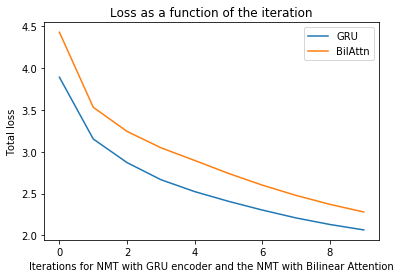

In [11]:
import pickle 

with open('loss_gru_9.txt','rb') as file:
    losses_gru = pickle.load(file)
        
with open('loss_bil_9.txt','rb') as file:
    losses_bil = pickle.load(file)
    
iteration= list(range(10))

plt.plot(iteration, losses_gru, label ='GRU')
plt.plot(iteration, losses_bil, label = 'BilAttn')
plt.xlabel("Iterations for NMT with GRU encoder and the NMT with Bilinear Attention")
plt.ylabel('Total loss')
plt.legend()
plt.title('Loss as a function of the iteration')
plt.savefig("mt_gru_bil.png")
plt.show()

In [35]:
for e in range(10):
    
    print(e)
    with open('model_NMT_bil_' + str(portion) + '_'+str(e)+'.pickle','rb') as file:
        model_NMT = pickle.load(file)
        
        write_test_eval(model_NMT, test_corpus2id_fr, test_corpus2id_en, str(portion), str(e), 'bil')
        
           

0
1
2
3
4
5
6
7
8
9


In [36]:
#get val sentences 

val_tokens_list_en,val_sentence_list_en = tokens_sentences(val_en)
val_tokens_list_fr,val_sentence_list_fr = tokens_sentences(val_fr)

val_corpus2id_en, val_corpus2id_fr = convert_corpora2id_both(val_sentence_list_en,val_sentence_list_fr, tokens2id_en, tokens2id_fr, max_sentence_length)

the number of sentences that were not added is 0


In [37]:
#write the results of the predicted sentences to a txt file for evaluation

def write_val_eval(model_NMT, val_sentences_fr, val_sentences_en, portion, e, label):

    filename = 'val_results_' + portion + '_' + e + '_' + label + '.txt'
    output = open(filename,"w") 
    
    for sent in range(len(val_sentences_fr)):

        decoder_outputs, decoder_attentions = evaluate_sent(model_NMT, val_sentences_fr[sent], val_sentences_en[sent])
        
        output_list = word_ids2string(decoder_outputs, id2tokens_en)
        if '<EOS>' in output_list:
            output_list.remove('<EOS>')
        
        output_string = (" ").join(output_list)
        
        output.write(output_string + "\n")

    output.close()
    

In [38]:
for e in range(10):
    
    print(e)
    with open('model_NMT_bil_' + str(portion) + '_'+str(e)+'.pickle','rb') as file:
        model_NMT = pickle.load(file)
        
        write_val_eval(model_NMT, val_corpus2id_fr, val_corpus2id_en, str(portion), str(e), 'bil')
        
           

0
1
2
3
4
5
6
7
8
9
